In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_excel('./Data/File1.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 28 columns):
Account Number        42 non-null int64
PortID                42 non-null object
Remaining Balance     42 non-null float64
interests Fees        42 non-null float64
Date Opened           42 non-null datetime64[ns]
Charge Off Date       42 non-null datetime64[ns]
Last Pay Date         38 non-null datetime64[ns]
Last Pay Amount       42 non-null float64
Last Activity Date    42 non-null datetime64[ns]
Interest Rate %       42 non-null float64
Issuer                42 non-null object
Merchant              42 non-null object
FCFRA Date            42 non-null datetime64[ns]
OOS Date              42 non-null datetime64[ns]
Account Type          42 non-null object
Last Name             42 non-null object
First Name            42 non-null object
Middle Name           28 non-null object
Address               42 non-null object
City                  42 non-null object
State                 42 n

## Feature Engineering

---

In [4]:
# Date the bundle was purchased
purchased_dt = pd.to_datetime('4/1/2008')

# Calculate the days until Out of Statute
df['OOS Days Left'] = df['OOS Date'] - purchased_dt

df['OOS Days Left'] = df.iloc[0]['OOS Days Left'].days

In [5]:
# Dummy up the Cycle as this is an important feature
df = pd.get_dummies(df, columns = ['Cycle'])
df.columns

Index(['Account Number', 'PortID', 'Remaining Balance', 'interests Fees',
       'Date Opened', 'Charge Off Date', 'Last Pay Date', 'Last Pay Amount',
       'Last Activity Date', 'Interest Rate %', 'Issuer', 'Merchant',
       'FCFRA Date', 'OOS Date', 'Account Type', 'Last Name', 'First Name',
       'Middle Name', 'Address', 'City', 'State', 'Zip', 'County', 'SSN',
       'Home Phone', 'Employer Phone', 'Paid', 'OOS Days Left',
       'Cycle_QUATERNARY', 'Cycle_SECONDARY', 'Cycle_TERTIARY'],
      dtype='object')

In [6]:
num_cols = df.columns[[np.issubdtype(dt, np.number) for dt in df.dtypes]]

drop_cols = [key for key in dict(df.dtypes) 
                if dict(df.dtypes)[key] in ['datetime64[ns]', 'object']]

# Add Paid to drop list
drop_cols.append('Paid')

In [7]:
num_cols

Index(['Account Number', 'Remaining Balance', 'interests Fees',
       'Last Pay Amount', 'Interest Rate %', 'SSN', 'Home Phone',
       'Employer Phone', 'Paid', 'OOS Days Left', 'Cycle_QUATERNARY',
       'Cycle_SECONDARY', 'Cycle_TERTIARY'],
      dtype='object')

In [8]:
y = df['Paid']
X = df.drop(columns = drop_cols)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [10]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

## Fitting and making predictions with the Logistic Regression model.

---

In [11]:
# Step 1: Instantiate our model.
logreg = LogisticRegression()

# Step 2: Fit our model.
logreg.fit(X_train_sc, y_train)

print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)

Logreg intercept: [-1.13063277]
Logreg coef(s): [[-0.17474582 -0.18989174  0.02904934  0.83306279  0.0500585   0.22059402
  -0.06816771 -0.10884952  0.          0.          0.0500585  -0.0500585 ]]


In [12]:
y_pred = logreg.predict(X_test_sc)
print('Logreg predicted:', y_pred)

Logreg predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]


### Confusion Matrix

In [13]:
metrics.confusion_matrix(y_test, y_pred)

array([[28,  2],
       [ 4,  0]])

In [14]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 28
False Positives: 2
False Negatives: 4
True Positives: 0


#### Confusion Matrix Evaluation Metrics
Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Well, you got a classification rate of 92%, considered as good accuracy.

- Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In your prediction case, when your Logistic Regression model predicted debtors will pay back 0%, of the time.

- Recall: If there are debtors who pay back in the test set and your Logistic Regression model can identify it 0% of the time.



In [15]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8235294117647058
Precision: 0.0
Recall: 0.0


#### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.5. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

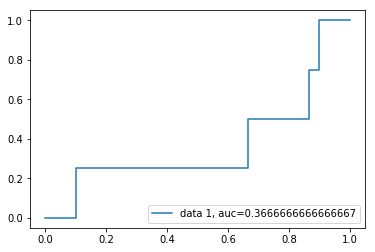

In [16]:
y_pred_proba = logreg.predict_proba(X_test_sc)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Fitting and making predictions with DecisionTreeClassifier model.

---

In [17]:
# criterion: splitting decision function, can be 'gini' or 'entropy'
# max_depth: the maximum number of hierarchical decision nodes(how "deep" the tree is 
# built)

classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None)

classifier.fit(X_train_sc, y_train)

y_pred = classifier.predict(X_test_sc)

# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = classifier.feature_importances_

In [18]:
feature_importances

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6764705882352942


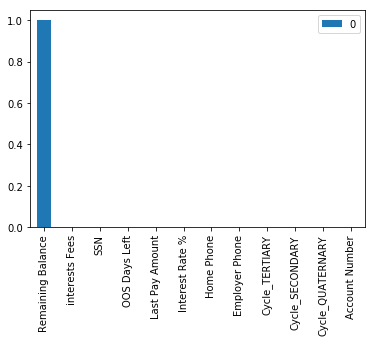

In [20]:
importances = list(zip(classifier.feature_importances_, X.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

## Fitting and making predictions with RandomForestClassifier model.

-----

In [21]:
#Create a Gaussian Classifier
classifier=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
classifier.fit(X_train_sc,y_train)

# prediction on test set
y_pred=classifier.predict(X_test_sc)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8823529411764706


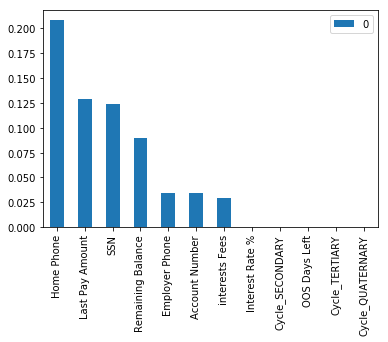

In [22]:
importances = list(zip(classifier.feature_importances_, X.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')

## Fitting and making predictions with KNeighborsClassifier model.

---

#### Instantiate KNN

For the `KNeighborsClassifier`, there a few important parameters to keep in mind:

1. `n_neighbors`: this is the "K" in KNN. The best K will change from problem to problem, but the default is 5.
2. `weights`: The neighbors can all have an equal vote (`uniform`), or the closer points can have a higher weighted vote (`distance`).
3. `p`: The distance metric. The default is Euclidean distance (2). Changing it to 1 is setting the distance to Manhattan.

In the cell below, instantiate a `knn` model using the default parameters.

In [23]:
features = ['Cycle_QUATERNARY', 'Cycle_SECONDARY', 'Cycle_TERTIARY']
X_knn = df[features]
y_knn = df['Paid']

# Split dataset into training set and test set 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.3) 

In [24]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9230769230769231


#### Cross validation

In the cell below, use `cross_val_score` to see what accuracy we can expect from our KNN model.

In [26]:
print(cross_val_score(knn, X_train, y_train).mean())

0.8653198653198654


In [ ]:
# pred_df = pd.DataFrame()

# paid = y
# paid.replace({1 :'yes', 0 : 'no'}, inplace=True)
# pred_df['paid'] = paid

# y_pred = pd.DataFrame(y_pred.reshape(len(y_pred), -1))
# pred_df['y_pred'] = y_pred

# pred_df